In [1]:
import geopandas as gpd

geodata = gpd.read_file("/home/gonzalo/Downloads/albufera.geojson")
geodata.explore()

## Query Sentinel-2 files from Element84

In [2]:
import satsearch

bbox = tuple(geodata.total_bounds) # (min lon, min lat, max lon, max lat)
dates = '2022-07-01/2022-08-15'

URL='https://earth-search.aws.element84.com/v0'
results = satsearch.Search.search(url=URL,
                                  collections=['sentinel-s2-l2a-cogs'], # note collection='sentinel-s2-l2a-cogs' doesn't work
                                  datetime=dates,
                                  bbox=bbox,    
                                  sort=['<datetime'])

In [3]:
print('%s items' % results.found())
items = results.items()
# Save this locally for use later


18 items


In [4]:
features = items.geojson()["features"]
len(features)

18

In [24]:
# items.geojson()["features"]

In [5]:
dates = items.dates()
dates

[datetime.date(2022, 7, 4),
 datetime.date(2022, 7, 9),
 datetime.date(2022, 7, 14),
 datetime.date(2022, 7, 19),
 datetime.date(2022, 7, 24),
 datetime.date(2022, 7, 29),
 datetime.date(2022, 8, 3),
 datetime.date(2022, 8, 8),
 datetime.date(2022, 8, 13)]

## Process one image

In [6]:
from shapely.geometry import shape
from georeader.readers import S2_SAFE_reader

bands = ["B04", "B03", "B02"]
feature = features[0]
s2obj = S2_SAFE_reader.s2_load_from_fearure(feature,bands=bands)
s2obj

 
         S2B_MSIL2A_20220813T104629_N0400_R051_T30SYJ_20220813T134325.SAFE
         Transform: | 10.00, 0.00, 699960.00|
| 0.00,-10.00, 4400040.00|
| 0.00, 0.00, 1.00|
         Shape: (3, 10980, 10980)
         Resolution: (10.0, 10.0)
         Bounds: (699960.0, 4290240.0, 809760.0, 4400040.0)
         CRS: EPSG:32630
         bands: ['B04', 'B03', 'B02']
         fill_value_default: 0
        

In [7]:
%%time
from georeader import read

data = read.read_from_bounds(s2obj, bbox,crs_bounds="EPSG:4326") # This does not trigger the download of the data
data_memory = data.load() # this triggers download only for the selected bands and within the bounds
data_memory

CPU times: user 851 ms, sys: 312 ms, total: 1.16 s
Wall time: 12.4 s


 
         Transform: | 10.00, 0.00, 720330.00|
| 0.00,-10.00, 4369680.00|
| 0.00, 0.00, 1.00|
         Shape: (3, 1150, 1074)
         Resolution: (10.0, 10.0)
         Bounds: (720330.0, 4358180.0, 731070.0, 4369680.0)
         CRS: EPSG:32630
         fill_value_default: 0
        

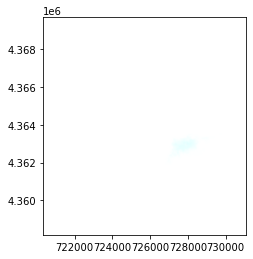

CPU times: user 545 ms, sys: 440 ms, total: 985 ms
Wall time: 362 ms


<AxesSubplot:>

In [8]:
%%time

import rasterio.plot as rstplt
import numpy as np

# From processing baseline PB04.00  values have an offset of 1_000
rstplt.show(np.clip(data_memory.values/10_000,0,1), transform=data_memory.transform)

## Process all the images

In [11]:
len(features)

18

 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                     | 14/18 [04:49<01:22, 20.65s/it]


CPU times: user 14.1 s, sys: 5.87 s, total: 19.9 s
Wall time: 4min 49s


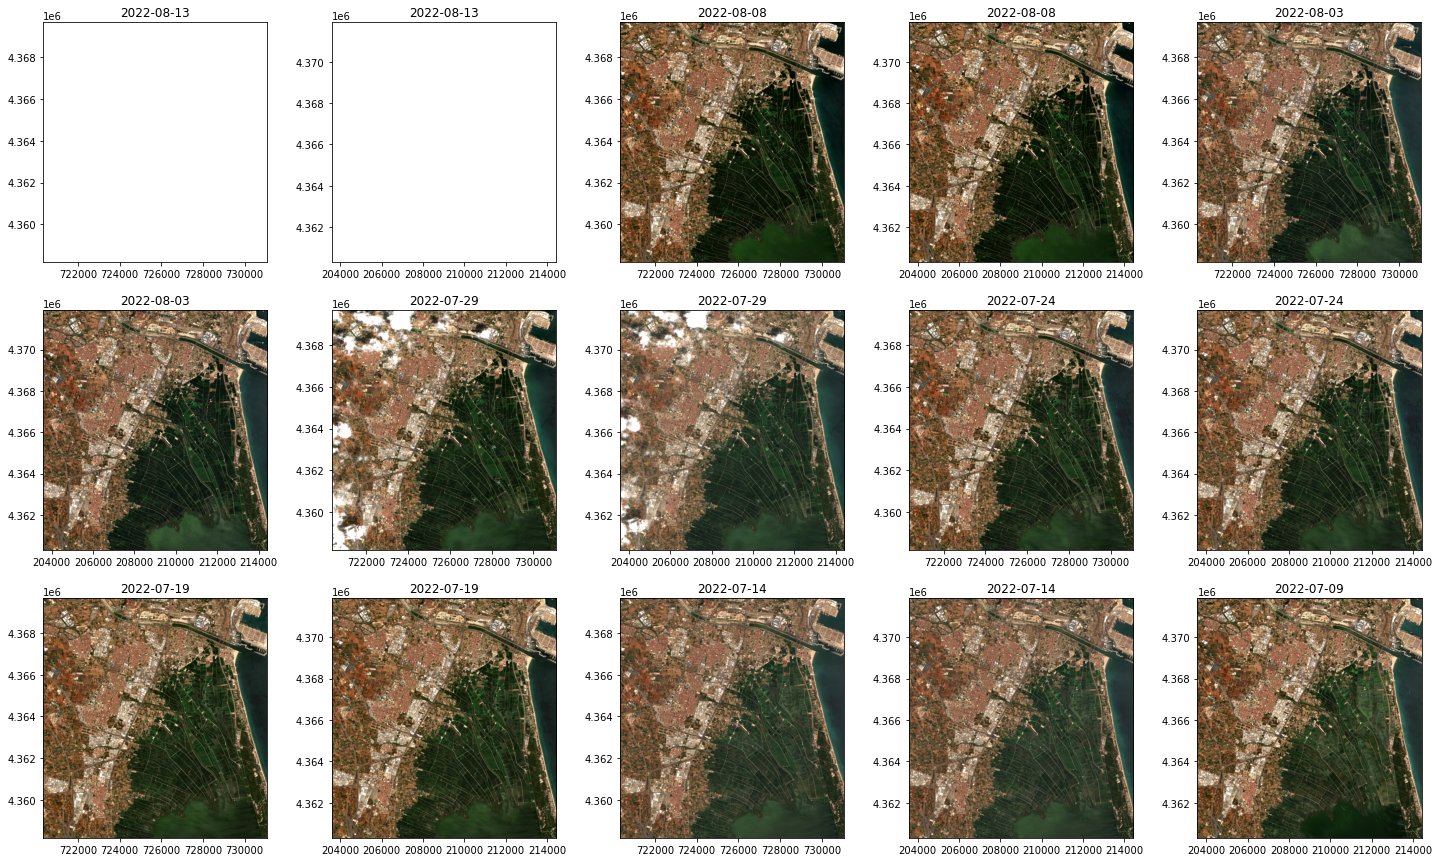

In [23]:
%%time

import matplotlib.pyplot as plt
from tqdm import tqdm

fig, ax = plt.subplots(3,5,figsize=(5*5,3*5))
ax = ax.flatten()

for _i, feature in tqdm(enumerate(features),total=len(features)):
    s2obj = S2_SAFE_reader.s2_load_from_fearure(feature,bands=bands)
    data_memory = read.read_from_bounds(s2obj, bbox,crs_bounds="EPSG:4326").load()
    rstplt.show(np.clip(data_memory.values/3_500,0,1), transform=data_memory.transform,ax=ax[_i])
    ax[_i].set_title(s2obj.datetime.strftime("%Y-%m-%d"))
    if _i == 14:
        break
    
    